In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_cell_based_tiny_net, get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

import torchvision.transforms as transforms
from PIL import Image

import tqdm

from xautodl.models.cell_searchs.search_cells import NAS201SearchCell

2022-10-26 13:15:11.726214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
# parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./tmp/', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

7399
Namespace(arch_nas_dataset='../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='../configs/nas-benchmark/algos/RANDOM.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=7399, save_dir='./tmp/', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 7399
save_dir         : ./tmp/
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


# Main

In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
if xargs.arch_nas_dataset is None:
    api = None
else:
    api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

logger.close()

Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=250, current::epoch=0, iter=0.00, type=cosine, T-max=250, eta-min=0

In [21]:
for layer in search_model.modules():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


# network_dict = torch.load("./25ep_step_supernet_weights.pth")
network_dict = torch.load("./250ep_supernet_weights.pth")
network.load_state_dict(network_dict,strict=False)


# network_dict = torch.load("../1020_cell_wise_random_supernet_train/cell_wise_25ep_step.pth")
# network_dict = torch.load("../1020_cell_wise_random_supernet_train/cell_wise_250ep_cosine.pth")
# network_dict = torch.load("./25ep_cosine_supernet_weights.pth")
# search_model.load_state_dict(network_dict)

<All keys matched successfully>

In [26]:
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)
t_list = [inv_normalize,
          transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#           transforms.RandomHorizontalFlip(p=1),
          transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1),
            scale=(0.9, 1.1), shear=0),
          transforms.Normalize(mean, std),]
random_transform = transforms.Compose(t_list)

def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        ###
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        ###
#         confidence = prob.max(dim=1)[0].sum() / inputs.size(0) * 100 # in percent
        ###
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, NAS201SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
#         for p in network.parameters():
#             p.add_(torch.randn_like(p) * p.std() * 0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
        
        
#         inputs_transform = random_transform(inputs)
#         import matplotlib.pyplot as plt
#         tmp = inputs[0].permute(1,2,0).cpu().numpy()
#         print(tmp.min(), tmp.max())
#         plt.imshow(tmp)
#         plt.show()
#         tmp = inputs_transform[0].permute(1,2,0).cpu().numpy()
#         print(tmp.min(), tmp.max())
#         plt.imshow(tmp)
#         plt.show()
#         asd
#         _, transformed_logits = network(inputs_transform)
#         kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
#         generalization = -kl_loss(torch.nn.functional.log_softmax(transformed_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
#     _, logits_large_step = network(inputs)
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
#     _, logits_small_step = network(inputs)
    small_step_dict = deepcopy(network.state_dict())
    ####
#     kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
#     step_sim = -kl_loss(torch.nn.functional.log_softmax(logits_small_step, dim=1), torch.nn.functional.softmax(logits_large_step, dim=1))
#     step_sim = step_sim.item()
    ###
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 0
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

def search_find_best_my(xloader, network, criterion, n_samples):
    archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
    loader_iter = iter(xloader)
    for i in tqdm.tqdm(range(n_samples)):
        arch = network.module.random_genotype(True)
        try:
            inputs, targets = next(loader_iter)
        except:
            loader_iter = iter(xloader)
            inputs, targets = next(loader_iter)
        inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
        valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
        step_sim = step_sim_metric(network, criterion, inputs, targets)

        archs.append(arch)
        metric_accs.append(valid_acc)
        metric_confidences.append(confidence)
        metric_sensitivities.append(sensitivity)
        metric_robustnesses.append(robustness)
        metric_step_sims.append(step_sim)

    return archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims
    # fittedness / confidence / responsiveness / (negative) over-fittedness / linearness

    
archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = search_find_best_my(valid_loader, network, criterion, 1000)

100%|██████████| 1000/1000 [18:35<00:00,  1.12s/it]


In [7]:
# ###full search
# from xautodl.models.cell_searchs.genotypes import Structure

# def search_find_best_my(xloader, network, criterion, all_archs):
#     archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
#     loader_iter = iter(xloader)
#     n_samples = len(all_archs)
#     for i in tqdm.tqdm(range(n_samples)):
#         arch = Structure.str2structure(all_archs[i])
#         network.arch_cache = arch
#         try:
#             inputs, targets = next(loader_iter)
#         except:
#             loader_iter = iter(xloader)
#             inputs, targets = next(loader_iter)
#         inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
#         valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
#         step_sim = step_sim_metric(network, criterion, inputs, targets)

#         archs.append(arch)
#         metric_accs.append(valid_acc)
#         metric_confidences.append(confidence)
#         metric_sensitivities.append(sensitivity)
#         metric_robustnesses.append(robustness)
#         metric_step_sims.append(step_sim)

#     return archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims
#     # fittedness / confidence / responsiveness / (negative) over-fittedness / linearness

    
# archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = search_find_best_my(valid_loader, network, criterion, api.meta_archs)

In [27]:
import scipy.stats as stats
rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
# rank_agg = rank_accs + rank_confidences + rank_sensitivities + rank_robustnesses + rank_step_sims
l = len(rank_accs)
rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
best_idx = np.argmax(rank_agg)

best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
# log
print("RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

# idx = np.argsort(rank_agg)[-5:]

# for best_idx in reversed(idx):
#     best_arch, best_acc, best_conf, best_sensitivity, best_robust = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx]
#     # log
#     print("RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust))
#     if api is not None:
#         print("{:}".format(api.query_by_arch(best_arch, "200")))

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=69.34%, confidence=58.270%, sensitivity=0.034, robustness=-0.016, step_sim=99.096
Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|)
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6111
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.22 ms.
cifar10-valid  train : [loss = 0.001, top1 = 99.99%], valid : [loss = 0.414, top1 = 91.61%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.22 ms.
cifar10   

In [28]:
def get_valid_acc_from_api(api, arch):
    # print(api.query_by_arch(arch, "200"))
    index = api.query_index_by_arch(arch)
    results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    acc = 0
    for seed, result in results.items():
        acc = acc + result.get_eval('valid')['accuracy']
    acc = acc / len(results)
    return acc

api_valid_accs = [get_valid_acc_from_api(api, a) for a in archs]

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=4214, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4214, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|skip_connect~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=11589, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11589, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=12906, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12906, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|avg_pool_3x3~2|)
Call query_by_index 

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=15302, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15302, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=5916, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5916, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=4822, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4822, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|avg_pool_3x3~2|)
Call q

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=1385, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1385, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|none~1|+|none~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=4303, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4303, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=13392, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13392, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index wi

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=2925, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2925, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=3529, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3529, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|nor_conv_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=2284, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2284, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_in

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|none~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=7572, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7572, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|skip_connect~2|)
Call query_by_index with arch_index=1288, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1288, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=6489, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6489, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|)


Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|skip_connect~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=11120, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11120, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=9194, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9194, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=6169, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6169, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|skip_connect~2|)
Call q

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=15371, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15371, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=14872, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14872, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|avg_pool_3x3~0|none~1|+|avg_pool_3x3~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=6191, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6191, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index 

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|skip_connect~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=9277, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9277, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=14709, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14709, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=4119, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4119, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|nor_conv_3x3~1|+|avg_pool_3x3~0|none~1|none~2|)
Call query_by_index with arch_index=6469, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6469, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=2849, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2849, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=4477, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4477, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=4199, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4199, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=12782, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12782, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=6431, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6431, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index wi

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=10409, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10409, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=5466, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5466, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=9595, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9595, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|none~1|+|none~0|skip_connect~1|nor_conv_1x1~2|)
Call query_by_

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=8212, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8212, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|none~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=5011, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5011, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=10835, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10835, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Call q

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=6853, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6853, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=9551, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9551, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=10709, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10709, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_1x1~2|)
Call query_by_

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=2605, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2605, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=13738, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13738, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=14025, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14025, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index 

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=4431, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4431, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=3410, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3410, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=1236, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1236, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_in

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|none~1|+|none~0|nor_conv_3x3~1|none~2|)
Call query_by_index with arch_index=8879, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8879, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=15471, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15471, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|none~2|)
Call query_by_index with arch_index=6110, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6110, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=13354, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13354, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=2337, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2337, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=13204, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13204, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=12645, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12645, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|avg_pool_3x3~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=12732, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12732, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=8891, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8891, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
Call query_b

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=5984, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5984, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|nor_conv_3x3~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=161, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=161, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|avg_pool_3x3~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=9807, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9807, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|)
Call query_by_index with arch_index=13304, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13304, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|nor_conv_3x3~0|none~1|none~2|)
Call query_by_index with arch_index=2937, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2937, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=2073, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2073, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=65

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=9231, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9231, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=11859, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11859, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=4522, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4522, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|)
Call q

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=9086, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9086, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=2923, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2923, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=2147, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2147, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|)


Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|none~1|none~2|)
Call query_by_index with arch_index=13047, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13047, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=9010, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9010, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|skip_connect~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=14017, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14017, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=

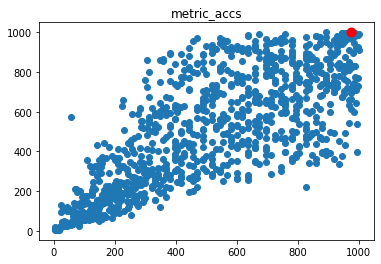

0.5819433491358714 1.4839348218420685e-165


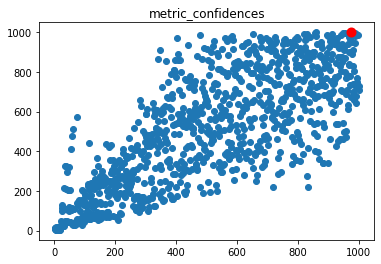

0.5837858199137443 3.5773091487535476e-168


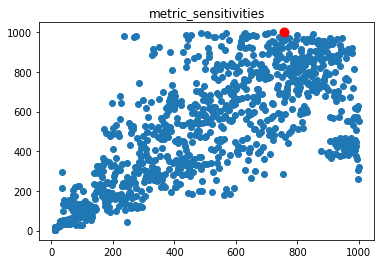

0.5525728507647539 7.830646226960684e-151


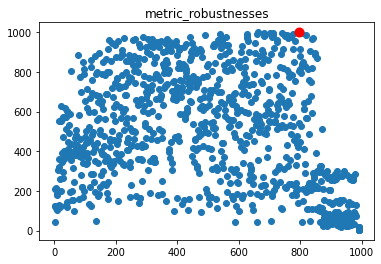

-0.15956033427840663 4.2345207198967585e-14


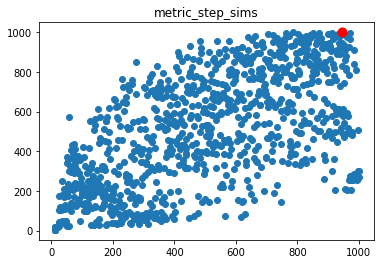

0.43827077272091103 1.2853610477512812e-95


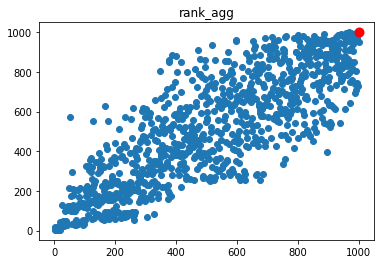

0.6538635972897253 1.9202280626356507e-210


In [29]:
import matplotlib.pyplot as plt
import scipy.stats as stats

x = stats.rankdata(np.array(metric_accs),"max")
# x = metric_accs
y = stats.rankdata(api_valid_accs,"max")
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_accs")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_confidences)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_sensitivities)
# x = metric_sensitivities
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_sensitivities")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_robustnesses)
# x = metric_robustnesses
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_robustnesses")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_step_sims)
# x = metric_robustnesses
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_step_sims")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [12]:
np.max(np.array(metric_accs))

73.046875

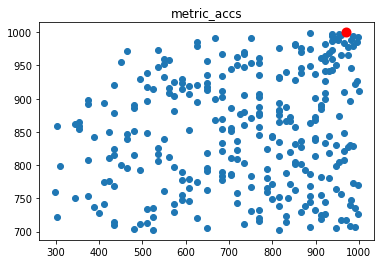

0.10666174806542678 0.00642318769176811


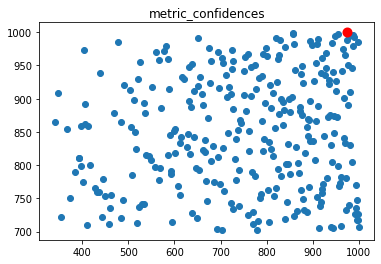

0.07271625288462522 0.060825568079198936


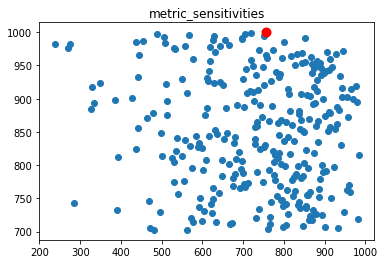

-0.03482028657735527 0.3693283061077216


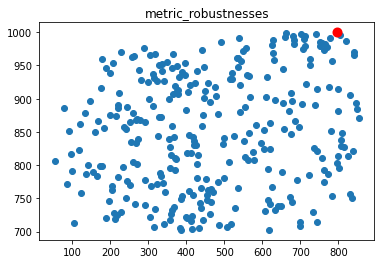

0.12331904201767406 0.0014758228180777398


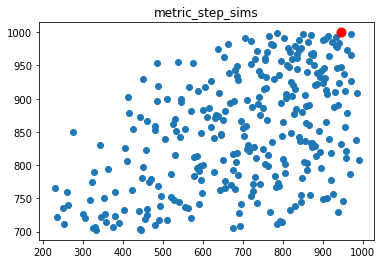

0.3152234969907448 4.398543379048995e-16


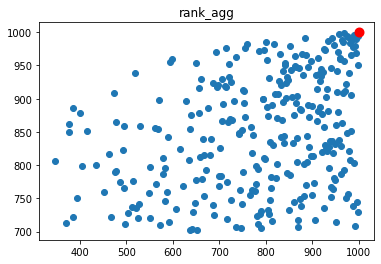

0.23646813573132366 1.0835372874495853e-09
RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=69.34%, confidence=58.270%, sensitivity=0.034, robustness=-0.016, generalization=99.096
Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|)
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6111
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.22 ms.
cifar10-valid  train : [loss = 0.001, top1 = 99.99%], valid : [loss = 0.414, top1 = 91.61%]
cifar10        FLOP=153.27

In [30]:
ratio = 0.7
med = np.sort(api_valid_accs)[int(len(api_valid_accs)*ratio)]
pos_idx = api_valid_accs > med
neg_idx = api_valid_accs <= med

# ratio = 0.5
# target = metric_accs
# med = np.median(target)
# med = np.sort(target)[int(len(target)*ratio)]
# pos_idx = target > med
# neg_idx = target <= med

# target = metric_confidences
# pruned_target = np.array(target)[pos_idx]
# med = np.median(pruned_target)
# med = np.sort(pruned_target)[int(len(pruned_target)*ratio)]
# pos_idx_tmp = target > med
# neg_idx_tmp = target <= med
# pos_idx = pos_idx & pos_idx_tmp
# neg_idx = neg_idx | neg_idx_tmp

# target = metric_sensitivities
# pruned_target = np.array(target)[pos_idx]
# med = np.median(pruned_target)
# med = np.sort(pruned_target)[int(len(pruned_target)*ratio)]
# pos_idx_tmp = target > med
# neg_idx_tmp = target <= med
# pos_idx = pos_idx & pos_idx_tmp
# neg_idx = neg_idx | neg_idx_tmp

# target = metric_robustnesses
# pruned_target = np.array(target)[pos_idx]
# med = np.median(pruned_target)
# med = np.sort(pruned_target)[int(len(pruned_target)*ratio)]
# pos_idx_tmp = target > med
# neg_idx_tmp = target <= med
# pos_idx = pos_idx & pos_idx_tmp
# neg_idx = neg_idx | neg_idx_tmp

# target = metric_step_sims
# pruned_target = np.array(target)[pos_idx]
# med = np.median(pruned_target)
# med = np.sort(pruned_target)[int(len(pruned_target)*ratio)]
# pos_idx_tmp = target > med
# neg_idx_tmp = target <= med
# pos_idx = pos_idx & pos_idx_tmp
# neg_idx = neg_idx | neg_idx_tmp

# from itertools import compress
# archs_pruned = list(compress(archs, pos_idx))
# metrics_pruned = [np.array(metric_accs)[pos_idx], np.array(metric_confidences)[pos_idx], np.array(metric_sensitivities)[pos_idx], np.array(metric_robustnesses)[pos_idx], np.array(metric_step_sims)[pos_idx]]
# ranks_pruned = []
# for metric in metrics_pruned:
#     ranks_pruned.append(stats.rankdata(metric))
# rank_agg_pruned = None
# for rank in ranks_pruned:
#     if rank_agg_pruned is None:
#         rank_agg_pruned = np.log(rank / len(rank))
#     else:
#         rank_agg_pruned += np.log(rank / len(rank))
# # print(rank)
# # print(rank_agg_pruned)
# # rank_agg_pruned = ranks_pruned[3]
# best_idx_pruned = np.argmax(rank_agg_pruned)
# best_arch_pruned = archs_pruned[best_idx_pruned]

# for i, a in enumerate(archs):
#     if a==best_arch_pruned:
#         best_idx = i
#         break
# print(best_arch_pruned)
# print(best_idx)

x = stats.rankdata(metric_accs)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_accs")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

x = stats.rankdata(metric_confidences)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

x = stats.rankdata(metric_sensitivities)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_sensitivities")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

x = stats.rankdata(metric_robustnesses)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_robustnesses")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

x = stats.rankdata(metric_step_sims)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_step_sims")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
# plt.scatter(x[neg_idx], y[neg_idx])
plt.scatter(x[pos_idx], y[pos_idx])
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
# tau, p_value = stats.kendalltau(x, y)
tau, p_value = stats.kendalltau(x[pos_idx], y[pos_idx])
print(tau, p_value)

best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
# log
print("RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, generalization={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))